In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import narrom

In [2]:
trajectories = narrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=200.npz')

# trajectories = trajectories[:100:1]

for k in range(len(trajectories)):
    trajectories[k] = trajectories[k].T

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 200


In [3]:
test_trajectory = narrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/example_run.npz')[0].T
print('example trajectory loaded with shape: ', test_trajectory.shape)

example trajectory loaded with shape:  (400, 200)


In [34]:
class DMD:
    
    def __init__(self, trajectories = None, rdim = 1):
        self.trajectories = trajectories
        if trajectories != None:
            self.n_trajectories = len(trajectories)
        self.rdim = rdim
    
    def load_trajectories(self, trajectories):
        self.trajectories = trajectories
        self.n_trajectories = len(trajectories)
    
    def train(self, rdim=None):
        
        if self.trajectories == None:
            raise ValueError('no trajectories loaded')
            
        if rdim != None:
            self.rdim = rdim

        X = []
        Xp = []
        for k in range(len(trajectories)):
            X.append( trajectories[k][:-1].T )
            Xp.append( trajectories[k][1:].T )

        X = np.concatenate(X, axis=1)
        Xprime = np.concatenate(Xp, axis=1)

#         print(X.shape)
#         print(Xprime.shape)
        
        U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
        Ur = U[:,:self.rdim]
        Sigmar = np.diag(Sigma[:self.rdim])
        VTr = VT[:self.rdim,:]
        Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
        self.Lambda, W = np.linalg.eig(Atilde) # Step 3
        self.Lambda = np.diag(self.Lambda)

        self.Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
#         alpha1 = Sigmar @ VTr[:,0]
#         b = np.linalg.solve(W @ Lambda,alpha1)
        
        
    def predict_single_run(self, run, rdim=None):
        if rdim == None:
            rdim = self.rdim
               
        self.b = np.linalg.pinv(self.Phi) @ run[0]

        pred = np.zeros(run.T.shape, dtype=complex)

        for k in range(pred.shape[1]):
            pred[:,k] = self.Phi @ np.linalg.matrix_power(self.Lambda,k) @ self.b

        return np.real(pred).T
    
    def get_error(self, run, approx=np.zeros(1), rdim=None, norm='NF'):
        
        if rdim == None:
            rdim = self.rdim
        
        if approx.size == 1:
            approx = self.predict_single_run(run, rdim=rdim)
        
        err=-1.
        if norm=='fro':
            err = np.linalg.norm(run-approx, ord='fro')       
        elif norm =='max':
            err = np.abs(run-approx).max()
        elif norm == 'NF':
            err = np.sqrt( np.mean( np.square(run-approx) ) )
        else:
            print('unknown norm') 

        return err
    
    def score_multiple_trajectories(self,trajectories,**kwargs):
        scores = []
        for k in range(len(trajectories)):
            scores.append(self.get_error(trajectories[k], **kwargs))
        
        mean = np.mean(scores)
        return mean, scores

In [36]:
model = DMD(trajectories)
model.train(rdim=20)

(200, 50)
(50, 50)


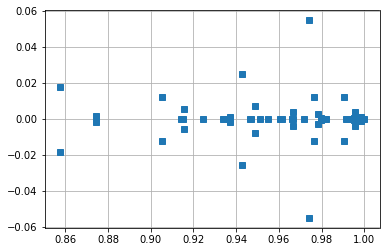

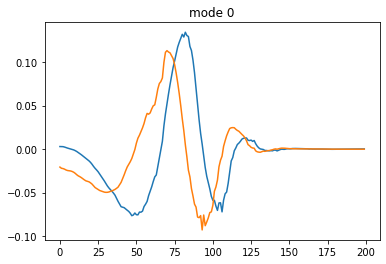

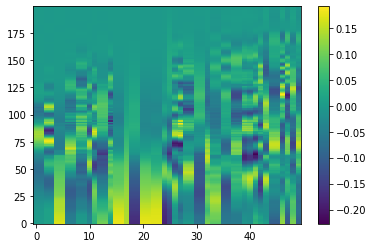

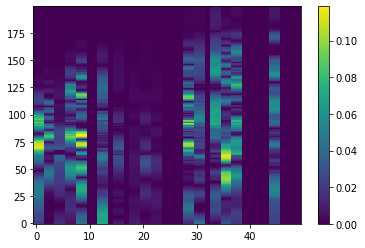

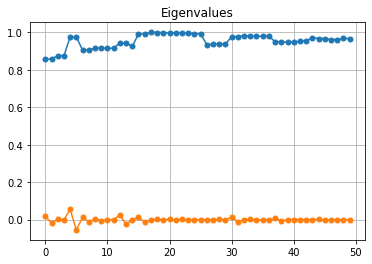

In [30]:
print(model.Phi.shape)
print(model.Lambda.shape)

plt.grid()
plt.plot(np.diag(np.real(model.Lambda)), np.diag(np.imag(model.Lambda)),'s')
plt.show()


n_mode = 0
plt.plot(np.real(model.Phi[:,n_mode]))
plt.plot(np.imag(model.Phi[:,n_mode]))
plt.title('mode '+str(n_mode))
plt.show()


plt.imshow(np.real(model.Phi), aspect='auto', interpolation='none', origin='lower')
plt.colorbar()
plt.show()

plt.imshow(np.abs(np.imag(model.Phi)), aspect='auto', interpolation='none', origin='lower')
plt.colorbar()
plt.show()


plt.grid()
plt.plot(np.diag(np.real(model.Lambda)), marker='o', ms=5)
plt.plot(np.diag(np.imag(model.Lambda)), marker='o', ms=5)
plt.title('Eigenvalues')
plt.show()

NF error:  0.04631773093058903
max error:  0.2196834641104785


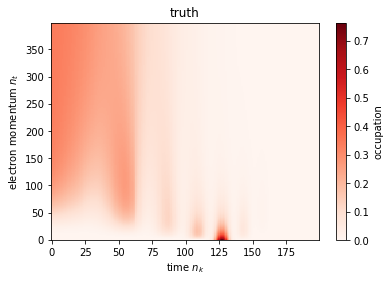

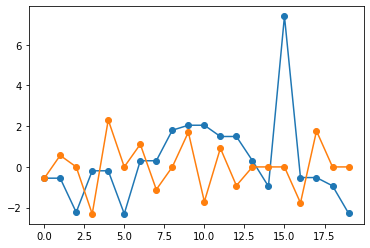

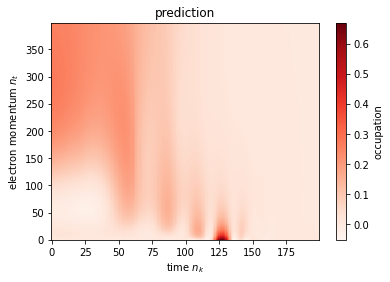

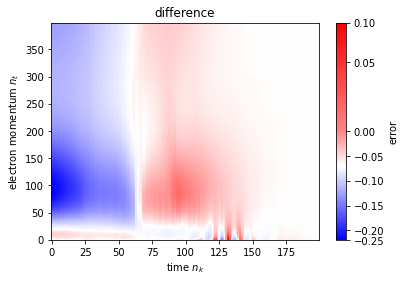

In [40]:
pred = model.predict_single_run(test_trajectory)

print('NF error: ', model.get_error(test_trajectory, pred, norm='NF'))
print('max error: ', model.get_error(test_trajectory, pred, norm='max'))

narrom.utils.plot_trajectory(test_trajectory,'truth')

plt.plot(np.real(model.b),marker='o')
plt.plot(np.imag(model.b),marker='o')
plt.show()

narrom.utils.plot_trajectory(pred,'prediction')

narrom.utils.plot_difference(test=pred, truth=test_trajectory)


In [42]:
model = DMD()

train_kwargs = {'rdim':20}

scores = narrom.utils.get_KFold_CV_scores(model, trajectories, folds=10, seed=817, norms=['NF','max'], train_kwargs=train_kwargs)

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

NF error:  0.04196839044843463 +- 0.02166195213438636
max error:  0.17668895147874947 +- 0.08359103338616845


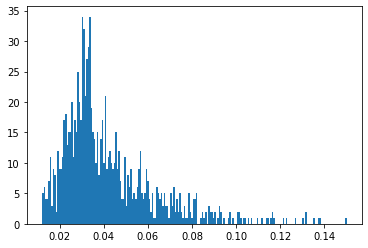

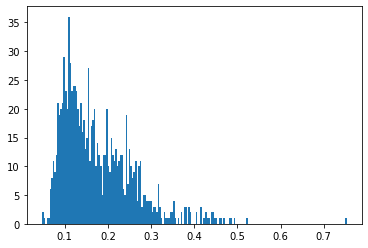

In [43]:
plt.hist(scores[0],bins=200)
plt.show()

plt.hist(scores[1],bins=200)
plt.show()